## Objective - To rank potential talents sources using search keywords and re-rank when a candidate is starred

### Tasks:
#### Ranking candidates based on a fitness score.

#### Re-ranking candidates when a candidate is starred.

### Output (desired target):
#### fit - how fit the candidate is for the role? (numeric, probability between 0-1)

### Keywords: 
#### “seeking human resources”


In [1]:
#import modules
import pandas as pd
import numpy as np
import nltk
import ssl
import os
import random
import matplotlib.pyplot as plt
import gensim.downloader as api
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim import models 
from gensim.models import KeyedVectors, Word2Vec
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec
from sentence_transformers import SentenceTransformer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sentence_transformers import SentenceTransformer
from LambdaRankNN  import RankNetNN, LambdaRankNN
from scipy.spatial.distance import cosine
from gensim.models import KeyedVectors
from itertools import combinations
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Loading Dataset

In [2]:
data_url = ("/Users/vidyakumar/Desktop/python/apziva/potential-talents - Aspiring human resources - seeking human resources.csv")
pd.set_option('display.max_colwidth', None)
get_ipython().run_line_magic('matplotlib', 'inline')

In [3]:
def load_data():
    data = pd.read_csv(data_url)
    return data

data = load_data()

data.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


## Exploratory Data Analysis

#### Check for duplicate rows

In [4]:
# When there is same job title in the same location, we consider it duplicate.
print(data.shape)
df_nodups = data.drop_duplicates(subset=['job_title', 'location'])
print(df_nodups.shape)

(104, 5)
(54, 5)


df_nodups.isnull().sum()

In [6]:
df_nodups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          54 non-null     int64  
 1   job_title   54 non-null     object 
 2   location    54 non-null     object 
 3   connection  54 non-null     object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.5+ KB


#### There are no null values, so no further action is needed on this regard.

## Data cleaning

#### Clean data to make it easy for the models to process the data

In [7]:
#replace acronymns
df_nodups['job_title'] = df_nodups['job_title'].str.replace("HRIS", " Human Resources Information System ")
df_nodups['job_title'] = df_nodups['job_title'].str.replace("HR", " Human Resources ")
df_nodups['job_title'] = df_nodups['job_title'].str.replace("EPIK", " English Program in Korea ")
df_nodups['job_title'] = df_nodups['job_title'].str.replace("JTI", " Japan Tobacco International ")

#removing stopwords and making it all lowercase
stop_words = set(stopwords.words('english'))
df_nodups['job_title_no_stpw'] = df_nodups['job_title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_nodups['job_title_no_stpw'] = df_nodups['job_title_no_stpw'].str.lower()
df_nodups.head(10)

,id,job_title,location,connection,fit,job_title_no_stpw
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN,2019 c.t. bauer college business graduate (magna cum laude) aspiring human resources professional
1,2,Native English Teacher at English Program in Korea,Kanada,500+,NaN,native english teacher english program korea
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspiring human resources professional
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member celal bayar university
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspiring human resources specialist
6,7,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN,student humber college aspiring human resources generalist
7,8,Human Resources Senior Specialist,San Francisco Bay Area,500+,NaN,human resources senior specialist
9,10,Seeking Human Resources Human Resources Information System and Generalist Positions,Greater Philadelphia Area,500+,NaN,seeking human resources human resources information system generalist positions
10,11,Student at Chapman University,"Lake Forest, California",2,NaN,student chapman university


In [8]:
#removing digits and special characters
df_nodups['job_title_no_splc'] = df_nodups['job_title_no_stpw'].str.replace(r'[^A-Za-z0-9 ]+', '', regex=True)
df_nodups['job_title_no_splc'] = df_nodups['job_title_no_splc'].str.replace(r'\d+','') 
df_nodups.head()

,id,job_title,location,connection,fit,job_title_no_stpw,job_title_no_splc
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN,2019 c.t. bauer college business graduate (magna cum laude) aspiring human resources professional,ct bauer college business graduate magna cum laude aspiring human resources professional
1,2,Native English Teacher at English Program in Korea,Kanada,500+,NaN,native english teacher english program korea,native english teacher english program korea
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspiring human resources professional,aspiring human resources professional
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator ryan,people development coordinator ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member celal bayar university,advisory board member celal bayar university


In [9]:
# lemmatize words in cleaned job title
lemmer = nltk.stem.WordNetLemmatizer()

def lem(words):
    return " ".join([lemmer.lemmatize(word,'v') for word in words.split()])

df_nodups['job_lemmatized'] =  df_nodups.job_title_no_splc.apply(lem)

df_nodups.head()

,id,job_title,location,connection,fit,job_title_no_stpw,job_title_no_splc,job_lemmatized
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN,2019 c.t. bauer college business graduate (magna cum laude) aspiring human resources professional,ct bauer college business graduate magna cum laude aspiring human resources professional,ct bauer college business graduate magna cum laude aspire human resources professional
1,2,Native English Teacher at English Program in Korea,Kanada,500+,NaN,native english teacher english program korea,native english teacher english program korea,native english teacher english program korea
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspiring human resources professional,aspiring human resources professional,aspire human resources professional
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator ryan,people development coordinator ryan,people development coordinator ryan
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member celal bayar university,advisory board member celal bayar university,advisory board member celal bayar university


## Vectorize job title using TF-IDF

#### Convert cleaned job titles into vectors

In [10]:
# Convert job_title column into a list
job_title_list = list(df_nodups['job_lemmatized'])                    

# Vectorize job_title_list
vectors = TfidfVectorizer()                                 
matrix = vectors.fit_transform(job_title_list)
feature_names = vectors.get_feature_names()  
print("Number of unique features: ", len(feature_names))   
print(feature_names)

Number of unique features:  175
['administration', 'administrative', 'admissions', 'advisory', 'always', 'america', 'an', 'analyst', 'analytics', 'army', 'arts', 'aspire', 'assistant', 'atlanta', 'bachelor', 'bauer', 'bayar', 'beach', 'beneteau', 'biology', 'board', 'brand', 'buckhead', 'business', 'care', 'celal', 'center', 'chapman', 'college', 'communications', 'community', 'compensation', 'conflict', 'coordinator', 'create', 'csr', 'ct', 'cum', 'customer', 'data', 'delphi', 'development', 'director', 'employment', 'endemol', 'energetic', 'energy', 'engage', 'engie', 'engineer', 'english', 'entrylevel', 'environment', 'environmental', 'excellence', 'executive', 'experience', 'ey', 'generalist', 'gi', 'gp', 'graduate', 'groupe', 'guard', 'hardware', 'heil', 'help', 'houston', 'human', 'humber', 'illinois', 'inc', 'inclusive', 'indiana', 'information', 'intelligence', 'intercontinental', 'international', 'internship', 'japan', 'junior', 'kokomo', 'korea', 'lab', 'laude', 'lead', 'lead

In [11]:
vectors.vocabulary_

{'ct': 36,
 'bauer': 15,
 'college': 28,
 'business': 23,
 'graduate': 61,
 'magna': 94,
 'cum': 37,
 'laude': 84,
 'aspire': 11,
 'human': 68,
 'resources': 134,
 'professional': 125,
 'native': 105,
 'english': 50,
 'teacher': 159,
 'program': 127,
 'korea': 82,
 'people': 120,
 'development': 41,
 'coordinator': 33,
 'ryan': 138,
 'advisory': 3,
 'board': 20,
 'member': 102,
 'celal': 25,
 'bayar': 16,
 'university': 166,
 'specialist': 149,
 'student': 153,
 'humber': 69,
 'generalist': 58,
 'senior': 143,
 'seek': 142,
 'information': 74,
 'system': 157,
 'position': 123,
 'chapman': 27,
 'svp': 156,
 'market': 99,
 'communications': 29,
 'csr': 35,
 'officer': 110,
 'engie': 48,
 'houston': 67,
 'the': 161,
 'woodlands': 172,
 'energy': 46,
 'gp': 60,
 'sp': 148,
 'intercontinental': 76,
 'buckhead': 22,
 'atlanta': 13,
 'management': 96,
 'internship': 78,
 'opportunities': 113,
 'experience': 56,
 'retail': 135,
 'manager': 98,
 'staff': 151,
 'recruit': 129,
 'luxottica': 93,


In [12]:
# Convert job titles into arrays
tfidf_vector = matrix.toarray()                                  
print("Shape of Tfidf vector: ", tfidf_vector.shape) 
print(tfidf_vector)

Shape of Tfidf vector:  (54, 175)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.46104593 0.         0.         ... 0.         0.         0.        ]]


In [13]:
print(tfidf_vector[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.19276841
 0.         0.         0.         0.3511579  0.         0.
 0.         0.         0.         0.         0.         0.26173515
 0.         0.         0.         0.         0.31815462 0.
 0.         0.         0.         0.         0.         0.
 0.3511579  0.3511579  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.31815462 0.         0.         0.         0.
 0.         0.         0.11589292 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.3511579  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.3511579  0.
 0.         0.         0.         0.    

## Apply Cosine Similarity

#### Calculate cosine similarity between document and the searched query

In [14]:
#search query
search = "Seeking human resources "
search = search.lower()

In [15]:
#cleaned search phrase
lemmer = nltk.stem.WordNetLemmatizer()
lem_search = " ".join([lemmer.lemmatize(word,'v') for word in search.split()])
print(lem_search)


seek human resources


In [16]:
# Convert search phrase into a vector
sv = vectors.transform([lem_search])                    
search_vector = sv.toarray()
print("Shape of search phrase vector:", search_vector.shape)
print(search_vector)

Shape of search phrase vector: (1, 175)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.4319816  0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.


In [17]:
# Calcualte TF-IDF cosine similarity & add a new column on the dataframe
cosine_sim = cosine_similarity(tfidf_vector, search_vector)

df_nodups['tfidf_sim_score'] = cosine_sim
df_nodups.sort_values(by ='tfidf_sim_score', ascending = False).head()

,id,job_title,location,connection,fit,job_title_no_stpw,job_title_no_splc,job_lemmatized,tfidf_sim_score
98,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,NaN,seeking human resources position,seeking human resources position,seek human resources position,0.696263
27,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,NaN,seeking human resources opportunities,seeking human resources opportunities,seek human resources opportunities,0.673137
72,73,"Aspiring Human Resources Manager, seeking internship in Human Resources.","Houston, Texas Area",7,NaN,"aspiring human resources manager, seeking internship human resources.",aspiring human resources manager seeking internship human resources,aspire human resources manager seek internship human resources,0.624745
9,10,Seeking Human Resources Human Resources Information System and Generalist Positions,Greater Philadelphia Area,500+,NaN,seeking human resources human resources information system generalist positions,seeking human resources human resources information system generalist positions,seek human resources human resources information system generalist position,0.517021
26,27,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,NaN,aspiring human resources management student seeking internship,aspiring human resources management student seeking internship,aspire human resources management student seek internship,0.459454


In [18]:
df_nodups.head()

,id,job_title,location,connection,fit,job_title_no_stpw,job_title_no_splc,job_lemmatized,tfidf_sim_score
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN,2019 c.t. bauer college business graduate (magna cum laude) aspiring human resources professional,ct bauer college business graduate magna cum laude aspiring human resources professional,ct bauer college business graduate magna cum laude aspire human resources professional,0.100127
1,2,Native English Teacher at English Program in Korea,Kanada,500+,NaN,native english teacher english program korea,native english teacher english program korea,native english teacher english program korea,0.000000
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspiring human resources professional,aspiring human resources professional,aspire human resources professional,0.298534
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator ryan,people development coordinator ryan,people development coordinator ryan,0.000000
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member celal bayar university,advisory board member celal bayar university,advisory board member celal bayar university,0.000000


## GloVe pre-trained model embeddings

#### GloVe is a count-based, unsupervised learning model that uses co-occurrence (how frequently two words appear together) statistics at a Global level to model the vector representations of words.

In [20]:
# load glove model
glove_model = api.load('glove-wiki-gigaword-300')

In [21]:
# find similarity
glove_model.wv.most_similar(positive=['dirty','grimy'],topn=10)


[('filthy', 0.6223560571670532),
 ('smelly', 0.6046320199966431),
 ('shabby', 0.5885416865348816),
 ('dingy', 0.5798770189285278),
 ('grubby', 0.5528677701950073),
 ('sweaty', 0.5256312489509583),
 ('soiled', 0.5006206631660461),
 ('grungy', 0.4955013692378998),
 ('gritty', 0.48847639560699463),
 ('dank', 0.48490819334983826)]

In [22]:
#glove embedding
tokens = []
for p in range(0, len(df_nodups)):
    token_words=[t for t in job_title_list[p].split() if t in glove_model.wv.vocab]
    token_search=[t for t in lem_search.split() if t in glove_model.wv.vocab]
    tokens.append(token_words)
len(token_search)

3

In [23]:
#glove embedding - cosine similarity
glove_cosine_similarity = []
for i in range(0, len(df_nodups)):
    cosine=0
    if (len(token_words) > 0 and len(token_search)>0):
        cosine=glove_model.wv.n_similarity(tokens[i],token_search)
        glove_cosine_similarity.append(cosine)
len(glove_cosine_similarity)

54

In [24]:
#Add glove_cosine_similarity column to the dataframe
df_nodups['glove_sim_score'] = glove_cosine_similarity
df_nodups.sort_values(by ='glove_sim_score', ascending = False).head()

,id,job_title,location,connection,fit,job_title_no_stpw,job_title_no_splc,job_lemmatized,tfidf_sim_score,glove_sim_score
27,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,NaN,seeking human resources opportunities,seeking human resources opportunities,seek human resources opportunities,0.673137,0.950269
98,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,NaN,seeking human resources position,seeking human resources position,seek human resources position,0.696263,0.946998
9,10,Seeking Human Resources Human Resources Information System and Generalist Positions,Greater Philadelphia Area,500+,NaN,seeking human resources human resources information system generalist positions,seeking human resources human resources information system generalist positions,seek human resources human resources information system generalist position,0.517021,0.926207
72,73,"Aspiring Human Resources Manager, seeking internship in Human Resources.","Houston, Texas Area",7,NaN,"aspiring human resources manager, seeking internship human resources.",aspiring human resources manager seeking internship human resources,aspire human resources manager seek internship human resources,0.624745,0.917465
73,74,Human Resources Professional,Greater Boston Area,16,NaN,human resources professional,human resources professional,human resources professional,0.364809,0.858967


## Word2Vec

#### Word2vec is a two-layer neural net that processes text by “vectorizing” words. Its input is a text corpus and its output is a set of vectors: feature vectors that represent words in that corpus.

#### There are two main training algorithims within Word2Vec: Continuous Bag of Words(CBOW) and Skip-Gram. The major difference between these two methods is that CBOW is using context to predict a target word while skip-gram is using a word to predict a target context. Generally, the skip-gram method can have a better performance compared with CBOW method. This is because it can capture two semantics for a single word.

In [26]:
# Set the pre trained model file path
mdl_name = "GoogleNews-vectors-negative300.bin"
mdl_file_path = os.path.join(os.path.abspath('') , "PreTrainedModel",mdl_name)

# Load the pre trained model
mdl_pre_trained = KeyedVectors.load_word2vec_format(mdl_file_path, binary = True)

In [27]:
# define a function for word embedding

def avg_word_embedding(sentence, model):
    words = sentence.split()
    word_embedding = []
    for word in words:
        if word in model:
            word_embedding.append(model[word])
        else:
            word_embedding.append(np.zeros(300)) # append zero vectors if the word is not present in the corpus
    word_embedding_avg = np.mean(word_embedding, axis=0)
    return word_embedding_avg

In [28]:
avg_keyword_embedding = avg_word_embedding(lem_search, mdl_pre_trained)
avg_keyword_embedding

array([-0.01578776,  0.08239746,  0.09342448,  0.10161337, -0.13460286,
        0.01475016,  0.17757161, -0.06495158, -0.06266276, -0.09138998,
       -0.08902995,  0.0067997 , -0.17024739,  0.16276042, -0.03898112,
        0.05790202, -0.134847  ,  0.11458334,  0.03346761,  0.01749674,
       -0.13427734, -0.2413737 ,  0.07014974,  0.00537109,  0.09232584,
       -0.14550781, -0.08666992,  0.09733073,  0.01439412, -0.17236328,
        0.00504557, -0.02278646, -0.2101237 , -0.11214193, -0.18977864,
        0.01660156,  0.0226237 ,  0.07405599,  0.17919922,  0.04410807,
        0.07462565,  0.171875  ,  0.00406901,  0.04435221, -0.08950806,
       -0.14501953, -0.08520508,  0.15934245, -0.04313151,  0.14166768,
       -0.01155599, -0.10286459, -0.08256022,  0.10782877, -0.17252605,
       -0.01310221, -0.08361816, -0.24153645,  0.10852051,  0.12816365,
       -0.02003988, -0.04498291,  0.04345703,  0.07486979, -0.13712566,
       -0.09895834,  0.0419515 ,  0.10791016, -0.21321614,  0.03

In [29]:
print(avg_keyword_embedding.shape)

(300,)


In [30]:
# create job title word embeddings
job_title_embeddings = []
for row in df_nodups['job_lemmatized']:
    # apply the avg_word_embedding function to each row and append to job_title_embeddings list
    job_title_embeddings.append(avg_word_embedding(row,mdl_pre_trained))
len(job_title_embeddings)    

54

In [31]:
job_title_embeddings[1].shape

(300,)

In [32]:
job_title_embeddings[1]

array([ 0.0164388 ,  0.0230306 ,  0.06384277,  0.07454427,  0.03114573,
        0.07866415,  0.08870443, -0.01574707, -0.09751383,  0.07039388,
        0.02640788, -0.22774251, -0.12898763, -0.17317708, -0.01647949,
        0.17317708,  0.0296224 ,  0.12093099,  0.03182475, -0.19193523,
        0.05558268,  0.20035808,  0.06575521, -0.04256185, -0.10139974,
       -0.0612793 , -0.12926643,  0.05080159,  0.03553263,  0.06067312,
        0.05891927,  0.04632568, -0.21374512, -0.1003418 , -0.0694987 ,
        0.0509847 , -0.01922607,  0.13932292,  0.15842693,  0.06195958,
        0.05061849, -0.13334148,  0.12078857,  0.20548503,  0.09082031,
       -0.01351929, -0.00409953, -0.02718099, -0.20715332,  0.16251628,
       -0.18261719, -0.07352702,  0.13200887, -0.02852376, -0.04801432,
       -0.00280762, -0.23779297, -0.08566284,  0.04051717, -0.20963542,
        0.08943304, -0.0897878 , -0.07845815, -0.13881429, -0.03959147,
       -0.15344238, -0.0685145 ,  0.04610189,  0.01407878,  0.08

In [33]:
# define a function for cosine similarity
def cosine_similarity(vec_A, vec_B):
    cos_sim = np.dot(vec_A, vec_B)/(np.linalg.norm(vec_A)* np.linalg.norm(vec_B))
    return cos_sim

In [34]:
similarity_scores = []
for job_title_embedding in job_title_embeddings:
    similarity_scores.append(cosine_similarity(avg_keyword_embedding, job_title_embedding))
print(similarity_scores)

[0.41483483, 0.116372764, 0.7384185, 0.3031234, 0.24507975897569403, 0.7766815, 0.6391586736237055, 0.70328295, 0.8765665, 0.15629324, 0.6856029866252424, 0.6150109418452812, 0.116372764, 0.73529315, 0.90574276, 0.6143283, 0.68312496, 0.7741559429766233, 0.5841986083242175, 0.59780174, 0.6848404820635017, 0.66903245, 0.85211736, 0.7956456, 0.7410181672185339, 0.63545936, 0.68411412154687, 0.7573833445737591, 0.6017099, 0.28756207, 0.655352, 0.6354607915200888, 0.5957557459736277, 0.612048, 0.21239294, 0.37554058, 0.21844117, 0.7486839, 0.68633574, 0.2783935681021081, 0.25622302, 0.48230952, 0.30414364, 0.74977535, 0.23430403450644086, 0.30923993354214885, 0.7384185, 0.12753598, 0.9214824, 0.7913723, 0.7573833445737591, 0.28454772, 0.13958569, 0.27461985937251926]


In [35]:
#adding word2vec similarity score to the dataframe
df_nodups['w2v_sim_score'] = similarity_scores
df_nodups.sort_values('w2v_sim_score',ascending=False ).head(10) # top 10 candidates 

,id,job_title,location,connection,fit,job_title_no_stpw,job_title_no_splc,job_lemmatized,tfidf_sim_score,glove_sim_score,w2v_sim_score
98,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,NaN,seeking human resources position,seeking human resources position,seek human resources position,0.696263,0.946998,0.921482
27,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,NaN,seeking human resources opportunities,seeking human resources opportunities,seek human resources opportunities,0.673137,0.950269,0.905743
9,10,Seeking Human Resources Human Resources Information System and Generalist Positions,Greater Philadelphia Area,500+,NaN,seeking human resources human resources information system generalist positions,seeking human resources human resources information system generalist positions,seek human resources human resources information system generalist position,0.517021,0.926207,0.876567
72,73,"Aspiring Human Resources Manager, seeking internship in Human Resources.","Houston, Texas Area",7,NaN,"aspiring human resources manager, seeking internship human resources.",aspiring human resources manager seeking internship human resources,aspire human resources manager seek internship human resources,0.624745,0.917465,0.852117
73,74,Human Resources Professional,Greater Boston Area,16,NaN,human resources professional,human resources professional,human resources professional,0.364809,0.858967,0.795646
99,100,Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis,"Cape Girardeau, Missouri",103,NaN,aspiring human resources manager | graduating may 2020 | seeking entry-level human resources position st. louis,aspiring human resources manager graduating may seeking entrylevel human resources position st louis,aspire human resources manager graduate may seek entrylevel human resources position st louis,0.384620,0.837180,0.791372
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspiring human resources specialist,aspiring human resources specialist,aspire human resources specialist,0.267109,0.850857,0.776681
67,68,Human Resources Specialist at Luxottica,Greater New York City Area,500+,NaN,human resources specialist luxottica,human resources specialist luxottica,human resources specialist luxottica,0.210309,0.748710,0.774156
77,78,Human Resources Generalist at Schwan's,Amerika Birleşik Devletleri,500+,NaN,human resources generalist schwan's,human resources generalist schwans,human resources generalist schwans,0.214116,0.812580,0.757383
100,101,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,NaN,human resources generalist loparex,human resources generalist loparex,human resources generalist loparex,0.214116,0.812580,0.757383


## BERT (Bidirectional Encoded Representations from Transformers)

#### The BERT framework was pre-trained using text from Wikipedia. BERT is based on Transformers, a deep learning model in which every output element is connected to every input element, and the weightings between them are dynamically calculated based upon their connection.

In [37]:
# Load the pre trained model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

In [38]:
# Convert job titles into BERT embedded vectors
bert_embeddings = bert_model.encode(job_title_list)
bert_embeddings.shape

(54, 384)

In [39]:
# Convert search phrase into a BERT embedded vector
bert_search_embedding = bert_model.encode(lem_search)
bert_search_embedding.shape

(384,)

In [40]:
# Calculate cosine similarity between job title and search phrase vectors
bert_cosine_similarity = []
for job_title_embedding in bert_embeddings:
    bert_cosine_similarity.append(cosine_similarity(bert_search_embedding, job_title_embedding))
print(bert_cosine_similarity)   

[0.30579787, 0.119350776, 0.60467726, 0.35315672, 0.1949653, 0.60285157, 0.52774286, 0.5741466, 0.68945366, 0.15860493, 0.55323386, 0.5148066, 0.119350776, 0.51941437, 0.8745638, 0.4565033, 0.6180409, 0.5522325, 0.5716723, 0.5610435, 0.5451984, 0.44962382, 0.59740925, 0.656326, 0.48579293, 0.54245514, 0.5141015, 0.57008535, 0.44678134, 0.18366054, 0.46509978, 0.51746684, 0.58021533, 0.45434725, 0.065068915, 0.13340901, 0.09187572, 0.55329597, 0.6008264, 0.23031276, 0.16485237, 0.34939793, 0.14150907, 0.591421, 0.10759773, 0.15723616, 0.60467726, 0.113456905, 0.88283396, 0.5626861, 0.5432345, 0.12035578, 0.06471833, 0.18269952]


In [41]:
#Add BERT_cosine_similarity column to the dataframe
df_nodups['BERT_sim_score'] = bert_cosine_similarity
df_nodups['BERT_sim_score'].head()

0    0.305798
1    0.119351
2    0.604677
3    0.353157
4    0.194965
Name: BERT_sim_score, dtype: float64

In [42]:
df_nodups.sort_values(by ='BERT_sim_score', ascending = False).head()

,id,job_title,location,connection,fit,job_title_no_stpw,job_title_no_splc,job_lemmatized,tfidf_sim_score,glove_sim_score,w2v_sim_score,BERT_sim_score
98,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,NaN,seeking human resources position,seeking human resources position,seek human resources position,0.696263,0.946998,0.921482,0.882834
27,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,NaN,seeking human resources opportunities,seeking human resources opportunities,seek human resources opportunities,0.673137,0.950269,0.905743,0.874564
9,10,Seeking Human Resources Human Resources Information System and Generalist Positions,Greater Philadelphia Area,500+,NaN,seeking human resources human resources information system generalist positions,seeking human resources human resources information system generalist positions,seek human resources human resources information system generalist position,0.517021,0.926207,0.876567,0.689454
73,74,Human Resources Professional,Greater Boston Area,16,NaN,human resources professional,human resources professional,human resources professional,0.364809,0.858967,0.795646,0.656326
66,67,"Human Resources, Staffing and Recruiting Professional","Jackson, Mississippi Area",500+,NaN,"human resources, staffing recruiting professional",human resources staffing recruiting professional,human resources staff recruit professional,0.182848,0.774561,0.683125,0.618041


## Fasttext

#### fastText is a library for learning of word embeddings and text classification created by Facebook's AI Research lab. The model allows one to create an unsupervised learning or supervised learning algorithm for obtaining vector representations for words.

In [44]:
# import fasttext library
import fasttext
import fasttext.util

In [45]:
# Load the pre trained model
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

In [46]:
ft.get_dimension()

300

In [47]:
ft.get_word_vector('hello').shape

(300,)

In [48]:
# get average key word embedding from fasttext model
avg_keyword_embedding_fasttext = avg_word_embedding(lem_search, ft)
print(avg_keyword_embedding_fasttext.shape)

(300,)


In [49]:
# create job title word embeddings
job_title_embeddings_ft = []
for row in df_nodups['job_lemmatized']:
    # apply the avg_word_embedding function to each row and append to job_title_embeddings list
    job_title_embeddings_ft.append(avg_word_embedding(row,ft))
len(job_title_embeddings_ft)    

54

In [72]:
job_title_embeddings_ft[-1]

array([ 2.9368460e-02, -2.8367694e-02,  4.9969006e-02, -3.9951328e-02,
        6.1198650e-03,  1.8996228e-02,  2.5086975e-02, -7.9187006e-03,
        2.5525218e-02, -1.6288513e-02, -4.5844540e-03, -1.1225432e-02,
        3.8311578e-02, -5.6497748e-03, -3.8149484e-02, -3.8468938e-02,
        2.5640442e-03,  8.2178913e-02,  3.5441376e-02,  6.3298168e-03,
       -1.0617355e-02, -3.9042563e-03,  4.4829525e-02,  3.8681630e-02,
       -5.0909221e-02, -4.1278776e-02, -7.5774536e-02,  5.3273151e-03,
       -9.6762776e-03,  1.1841943e-01,  3.1494923e-02, -5.9376364e-03,
        5.6040060e-02, -4.5287319e-02, -4.2982183e-02, -2.9282341e-02,
        6.8295695e-02,  5.6341827e-02, -4.4567149e-02, -3.1513006e-03,
       -4.2883433e-02, -1.3379631e-02,  8.8938717e-03, -9.0169143e-03,
       -6.3204922e-02, -1.0077165e-01, -4.1812955e-04, -4.5309644e-02,
        2.5931109e-02,  8.2048019e-03,  1.8113350e-02,  1.3145521e-02,
        4.2534145e-03, -3.4084737e-02,  8.6305884e-04, -1.9162526e-02,
      

In [51]:
# Calculate cosine similarity between job title and search phrase vectors
similarity_scores_fasttext = []
for job_title_embedding in job_title_embeddings_ft:
    similarity_scores_fasttext.append(cosine_similarity(avg_keyword_embedding_fasttext, job_title_embedding))
print(similarity_scores_fasttext)

[0.30384836, 0.23638754, 0.7698047, 0.22312275, 0.22215024305604214, 0.78443325, 0.5890791, 0.67603666, 0.9128277, 0.2436416, 0.35593957, 0.51813644, 0.23638754, 0.87431324, 0.9886235, 0.6458251, 0.67755026, 0.767169546248991, 0.5052692632920064, 0.65152186, 0.4750866517811976, 0.6349358, 0.917272, 0.7681606, 0.8264363414183757, 0.7279492, 0.6885473036804692, 0.7384011221043086, 0.5591659, 0.2562655, 0.54112536, 0.46459245438102925, 0.5719604155973999, 0.38109446, 0.11169973, 0.44963104, 0.25181028, 0.6511752, 0.39830357, 0.23109285431042223, 0.35994723, 0.6814653, 0.3447572, 0.8446684, 0.28612706, 0.28742534, 0.7698047, 0.25724337, 0.9727639, 0.61706716, 0.7384011221043086, 0.37011304, 0.29020116, 0.2801095]


In [52]:
#Add fasttext cosine similarity scores to the dataframe
df_nodups['ft_sim_score'] = similarity_scores_fasttext
df_nodups.sort_values('ft_sim_score',ascending=False ).head(10) 

,id,job_title,location,connection,fit,job_title_no_stpw,job_title_no_splc,job_lemmatized,tfidf_sim_score,glove_sim_score,w2v_sim_score,BERT_sim_score,ft_sim_score
27,28,Seeking Human Resources Opportunities,"Chicago, Illinois",390,NaN,seeking human resources opportunities,seeking human resources opportunities,seek human resources opportunities,0.673137,0.950269,0.905743,0.874564,0.988623
98,99,Seeking Human Resources Position,"Las Vegas, Nevada Area",48,NaN,seeking human resources position,seeking human resources position,seek human resources position,0.696263,0.946998,0.921482,0.882834,0.972764
72,73,"Aspiring Human Resources Manager, seeking internship in Human Resources.","Houston, Texas Area",7,NaN,"aspiring human resources manager, seeking internship human resources.",aspiring human resources manager seeking internship human resources,aspire human resources manager seek internship human resources,0.624745,0.917465,0.852117,0.597409,0.917272
9,10,Seeking Human Resources Human Resources Information System and Generalist Positions,Greater Philadelphia Area,500+,NaN,seeking human resources human resources information system generalist positions,seeking human resources human resources information system generalist positions,seek human resources human resources information system generalist position,0.517021,0.926207,0.876567,0.689454,0.912828
26,27,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,NaN,aspiring human resources management student seeking internship,aspiring human resources management student seeking internship,aspire human resources management student seek internship,0.459454,0.806649,0.735293,0.519414,0.874313
93,94,Seeking Human Resources Opportunities. Open to travel and relocation.,Amerika Birleşik Devletleri,415,NaN,seeking human resources opportunities. open travel relocation.,seeking human resources opportunities open travel relocation,seek human resources opportunities open travel relocation,0.368938,0.855546,0.749775,0.591421,0.844668
74,75,"Nortia Staffing is seeking Human Resources, Payroll & Administrative Professionals!! (408) 709-2621","San Jose, California",500+,NaN,"nortia staffing seeking human resources, payroll & administrative professionals!! (408) 709-2621",nortia staffing seeking human resources payroll administrative professionals,nortia staff seek human resources payroll administrative professionals,0.328632,0.802435,0.741018,0.485793,0.826436
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspiring human resources specialist,aspiring human resources specialist,aspire human resources specialist,0.267109,0.850857,0.776681,0.602852,0.784433
96,97,Aspiring Human Resources Professional,"Kokomo, Indiana Area",71,NaN,aspiring human resources professional,aspiring human resources professional,aspire human resources professional,0.298534,0.806942,0.738419,0.604677,0.769805
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspiring human resources professional,aspiring human resources professional,aspire human resources professional,0.298534,0.806942,0.738419,0.604677,0.769805


In [106]:
# create a copy dataframe 
dfnodups_cp = df_nodups.copy()

In [107]:
# reset index
newdf = dfnodups_cp.reset_index()

#### Since we have identified fastText model embeddings as the best way to rank our candidates, we will utilize the fastText model scores and allow the user to re-rank the data as per the requirement.

## Learning to Rank

#### Assigning new scores(as needed) and Re-ranking job titles when a candidate is starred by user

In [108]:
#Taking input from user - starred candidates
star_candidate = input("Do you want to star any candidates? Enter 'Yes' or 'No': ")

starred = []
if star_candidate == 'Yes':
    starred = [int(item) for item in input("Enter ids of candidates you want to star (separated by space) : ").split()]

Do you want to star any candidates? Enter 'Yes' or 'No': Yes
Enter ids of candidates you want to star (separated by space) : 1 4


In [109]:
newdf['starred_score'] = newdf['ft_sim_score']

In [111]:
newdf.loc[newdf['id'].isin(starred), 'starred_score'] = 1
newdf

,index,id,job_title,location,connection,fit,job_title_no_stpw,job_title_no_splc,job_lemmatized,tfidf_sim_score,glove_sim_score,w2v_sim_score,BERT_sim_score,ft_sim_score,starred_score
0,0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN,2019 c.t. bauer college business graduate (magna cum laude) aspiring human resources professional,ct bauer college business graduate magna cum laude aspiring human resources professional,ct bauer college business graduate magna cum laude aspire human resources professional,0.100127,0.445459,0.414835,0.305798,0.303848,1.000000
1,1,2,Native English Teacher at English Program in Korea,Kanada,500+,NaN,native english teacher english program korea,native english teacher english program korea,native english teacher english program korea,0.000000,0.371722,0.116373,0.119351,0.236388,0.236388
2,2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN,aspiring human resources professional,aspiring human resources professional,aspire human resources professional,0.298534,0.806942,0.738419,0.604677,0.769805,0.769805
3,3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN,people development coordinator ryan,people development coordinator ryan,people development coordinator ryan,0.000000,0.525044,0.303123,0.353157,0.223123,1.000000
4,4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN,advisory board member celal bayar university,advisory board member celal bayar university,advisory board member celal bayar university,0.000000,0.308849,0.245080,0.194965,0.222150,0.222150
5,5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN,aspiring human resources specialist,aspiring human resources specialist,aspire human resources specialist,0.267109,0.850857,0.776681,0.602852,0.784433,0.784433
6,6,7,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN,student humber college aspiring human resources generalist,student humber college aspiring human resources generalist,student humber college aspire human resources generalist,0.154655,0.597689,0.639159,0.527743,0.589079,0.589079
7,7,8,Human Resources Senior Specialist,San Francisco Bay Area,500+,NaN,human resources senior specialist,human resources senior specialist,human resources senior specialist,0.221372,0.804828,0.703283,0.574147,0.676037,0.676037
8,9,10,Seeking Human Resources Human Resources Information System and Generalist Positions,Greater Philadelphia Area,500+,NaN,seeking human resources human resources information system generalist positions,seeking human resources human resources information system generalist positions,seek human resources human resources information system generalist position,0.517021,0.926207,0.876567,0.689454,0.912828,0.912828
9,10,11,Student at Chapman University,"Lake Forest, California",2,NaN,student chapman university,student chapman university,student chapman university,0.000000,0.254033,0.156293,0.158605,0.243642,0.243642


In [112]:
class Rank_Net( tf.keras.Model):
    ''' 
    Rank_Net customized class for re-ranking
    '''
    def __init__(self):
        super().__init__()
        self.model = tf.keras.Sequential()
        # Add the input layer
        self.model.add(tf.keras.layers.Input(shape=(300)))
        self.model.add(tf.keras.layers.Dense(400, activation='linear', name='input_layer_1'))
        self.model.add(tf.keras.layers.Dropout(rate=0.2, name='dropout_layer_1'))
        self.model.add(tf.keras.layers.Dense(800, activation=tf.nn.leaky_relu, name='input_layer_2'))
        self.model.add(tf.keras.layers.Dropout(rate=0.2, name='dropout_layer_2'))
        self.model.add(tf.keras.layers.Dense(200, activation=tf.nn.leaky_relu, name='input_layer_3'))
        self.model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer'))

        
    def call(self, inputs):
        input1, input2 = inputs
        #model 1 
        s1 = self.model(input1)
        s2 = self.model(input2)
        out = tf.nn.sigmoid(s1-s2)
        return out
    
    def build_graph(self):
        X = [ tf.keras.layers.Input(shape=(300)), tf.keras.layers.Input(shape=(300))]
        return tf.keras.Model(inputs=X,outputs=self.call(X))
    
    def predict(self, input_):
        s = self.model(input_)
        return s

In [113]:
newdf['EmbeddingArrays'] = pd.Series(job_title_embeddings_ft)

In [114]:
newdf.shape

(54, 16)

In [115]:
newdf.loc[newdf.EmbeddingArrays.isna()]

,index,id,job_title,location,connection,fit,job_title_no_stpw,job_title_no_splc,job_lemmatized,tfidf_sim_score,glove_sim_score,w2v_sim_score,BERT_sim_score,ft_sim_score,starred_score,EmbeddingArrays


#### Generate random sample for input pair using sample method with replacement

In [116]:
# fetch the random input rows for input
sample_size = 125
random_row_1 = newdf.sample(n=sample_size, replace=True)
random_row_2 = newdf.sample(n=sample_size, replace=True)

In [117]:
X_1 = random_row_1['EmbeddingArrays'].values
X_2 = random_row_2['EmbeddingArrays'].values
Y_1 = random_row_1['starred_score'].values
Y_2 = random_row_2['starred_score'].values

In [118]:
X_1.shape

(125,)

In [119]:
# Generate combinations
lst_combinations = list(combinations(range(sample_size), 2))
sample_pair = int(len(lst_combinations)* 0.70)

In [120]:
# select samples randomly
random_pairs = [ random.randrange(len(lst_combinations)) for i in range(sample_pair)]

In [121]:
# create empty lists for storing pairs
X_i = []
X_j = []
output_ij = []
pair_id = []

for idx in range(0,sample_pair):
    # Store the pair Id's
    pair_values = lst_combinations[random_pairs[idx] ]
    pair_id.append(pair_values)

    # fetch the input indexes
    i, j = pair_values

    # append in Xi and Xj
    X_i.append(X_1[i])
    X_j.append(X_2[j])

    # Check the scores 
    if Y_1[i] == Y_2[j]:
        _result_ij = 0.5
    elif Y_1[i] > Y_2[j]:
        _result_ij = 1.0
    else:
        _result_ij = 0.0

    output_ij.append(_result_ij)

In [122]:
# Convert the list into numpy arrays
X_i = np.array(X_i)
X_j = np.array(X_j)
output_ij = np.array(output_ij)
pair_id = np.array(pair_id)

# Perform Test Train split to get validation data 
xi_train, xi_val, xj_train, xj_val, pij_train, pij_val, pair_id_train, pair_id_val = train_test_split(
    X_i, X_j, output_ij, pair_id, test_size=0.2)

In [123]:
# Train the network
ranknet = Rank_Net()

# Define criteria for early stopping(Stop training when a monitored metric has stopped improving)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

# compile the model
ranknet.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), 
                loss='binary_crossentropy')

In [124]:
# Train the model
historyRank_Net = ranknet.fit([xi_train, xj_train], pij_train, epochs=2000, 
                      validation_data=([xi_val, xj_val], pij_val),
                              callbacks =[callback])

Epoch 1/2000
136/136 [==============================] - 3s 10ms/step - loss: 0.6934 - val_loss: 0.6933
Epoch 2/2000
136/136 [==============================] - 1s 9ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/2000
136/136 [==============================] - 2s 14ms/step - loss: 0.6930 - val_loss: 0.6928
Epoch 4/2000
136/136 [==============================] - 2s 11ms/step - loss: 0.6929 - val_loss: 0.6926
Epoch 5/2000
136/136 [==============================] - 2s 14ms/step - loss: 0.6925 - val_loss: 0.6924
Epoch 6/2000
136/136 [==============================] - 1s 10ms/step - loss: 0.6925 - val_loss: 0.6921
Epoch 7/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.6923 - val_loss: 0.6919
Epoch 8/2000
136/136 [==============================] - 1s 10ms/step - loss: 0.6921 - val_loss: 0.6917
Epoch 9/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.6919 - val_loss: 0.6914
Epoch 10/2000
136/136 [==============================] - 1s 9ms/step - loss:

136/136 [==============================] - 1s 9ms/step - loss: 0.6765 - val_loss: 0.6739
Epoch 81/2000
136/136 [==============================] - 1s 9ms/step - loss: 0.6762 - val_loss: 0.6736
Epoch 82/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.6758 - val_loss: 0.6732
Epoch 83/2000
136/136 [==============================] - 1s 9ms/step - loss: 0.6756 - val_loss: 0.6729
Epoch 84/2000
136/136 [==============================] - 1s 9ms/step - loss: 0.6752 - val_loss: 0.6726
Epoch 85/2000
136/136 [==============================] - 1s 9ms/step - loss: 0.6750 - val_loss: 0.6722
Epoch 86/2000
136/136 [==============================] - 1s 9ms/step - loss: 0.6747 - val_loss: 0.6719
Epoch 87/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.6743 - val_loss: 0.6715
Epoch 88/2000
136/136 [==============================] - 1s 9ms/step - loss: 0.6740 - val_loss: 0.6712
Epoch 89/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.6736 - v

Epoch 159/2000
136/136 [==============================] - 1s 11ms/step - loss: 0.6375 - val_loss: 0.6318
Epoch 160/2000
136/136 [==============================] - 2s 11ms/step - loss: 0.6366 - val_loss: 0.6310
Epoch 161/2000
136/136 [==============================] - 2s 11ms/step - loss: 0.6358 - val_loss: 0.6302
Epoch 162/2000
136/136 [==============================] - 2s 12ms/step - loss: 0.6349 - val_loss: 0.6293
Epoch 163/2000
136/136 [==============================] - 2s 11ms/step - loss: 0.6344 - val_loss: 0.6285
Epoch 164/2000
136/136 [==============================] - 2s 11ms/step - loss: 0.6334 - val_loss: 0.6276
Epoch 165/2000
136/136 [==============================] - 1s 11ms/step - loss: 0.6328 - val_loss: 0.6267
Epoch 166/2000
136/136 [==============================] - 2s 12ms/step - loss: 0.6318 - val_loss: 0.6259
Epoch 167/2000
136/136 [==============================] - 1s 9ms/step - loss: 0.6311 - val_loss: 0.6250
Epoch 168/2000
136/136 [==============================] 

136/136 [==============================] - 1s 9ms/step - loss: 0.5674 - val_loss: 0.5602
Epoch 238/2000
136/136 [==============================] - 2s 10ms/step - loss: 0.5665 - val_loss: 0.5594
Epoch 239/2000
136/136 [==============================] - 1s 10ms/step - loss: 0.5657 - val_loss: 0.5587
Epoch 240/2000
136/136 [==============================] - 1s 10ms/step - loss: 0.5654 - val_loss: 0.5580
Epoch 241/2000
136/136 [==============================] - 1s 9ms/step - loss: 0.5642 - val_loss: 0.5572
Epoch 242/2000
136/136 [==============================] - 2s 11ms/step - loss: 0.5637 - val_loss: 0.5565
Epoch 243/2000
136/136 [==============================] - 1s 10ms/step - loss: 0.5632 - val_loss: 0.5558
Epoch 244/2000
136/136 [==============================] - 1s 9ms/step - loss: 0.5617 - val_loss: 0.5551
Epoch 245/2000
136/136 [==============================] - 1s 10ms/step - loss: 0.5615 - val_loss: 0.5544
Epoch 246/2000
136/136 [==============================] - 1s 10ms/step - 

136/136 [==============================] - 1s 8ms/step - loss: 0.5277 - val_loss: 0.5234
Epoch 316/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5283 - val_loss: 0.5231
Epoch 317/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5276 - val_loss: 0.5229
Epoch 318/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5274 - val_loss: 0.5227
Epoch 319/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5276 - val_loss: 0.5224
Epoch 320/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5271 - val_loss: 0.5222
Epoch 321/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5266 - val_loss: 0.5219
Epoch 322/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5266 - val_loss: 0.5217
Epoch 323/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5257 - val_loss: 0.5215
Epoch 324/2000
136/136 [==============================] - 1s 8ms/step - loss: 0

Epoch 394/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5150 - val_loss: 0.5117
Epoch 395/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5151 - val_loss: 0.5116
Epoch 396/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5149 - val_loss: 0.5115
Epoch 397/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5143 - val_loss: 0.5114
Epoch 398/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5149 - val_loss: 0.5113
Epoch 399/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5149 - val_loss: 0.5113
Epoch 400/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5144 - val_loss: 0.5112
Epoch 401/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5137 - val_loss: 0.5111
Epoch 402/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5140 - val_loss: 0.5110
Epoch 403/2000
136/136 [==============================] - 1s 8ms

Epoch 473/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5099 - val_loss: 0.5075
Epoch 474/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5097 - val_loss: 0.5075
Epoch 475/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5102 - val_loss: 0.5074
Epoch 476/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5097 - val_loss: 0.5074
Epoch 477/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5100 - val_loss: 0.5074
Epoch 478/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5098 - val_loss: 0.5073
Epoch 479/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5097 - val_loss: 0.5073
Epoch 480/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5100 - val_loss: 0.5073
Epoch 481/2000
136/136 [==============================] - 1s 8ms/step - loss: 0.5093 - val_loss: 0.5072
Epoch 482/2000
136/136 [==============================] - 1s 8ms

In [127]:
def plot_learning( hist, metric):
    
    plt.title(metric + " Learning plot")
    plt.plot(hist[metric], color='blue', label='train_' +metric)
    plt.plot(hist['val_' + metric], color='red', label='val_' + metric)
    plt.xlabel(xlabel="No Of Training Epochs")
    plt.ylabel(ylabel=metric)
    plt.legend(loc="upper right")
    plt.show()

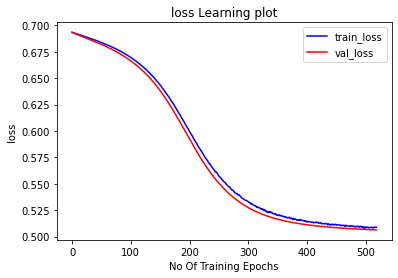

In [128]:
# Plot the loss 
plot = plot_learning(historyRank_Net.history, "loss")

In [129]:
# Input list of embeddings
input_lst = list(newdf['EmbeddingArrays'].values)
input_arr = np.array(np.stack( input_lst, axis=0 ))

# predict the score using ranknet 
newdf['ranknet_score_1'] = list(ranknet.predict(input_arr).numpy())

In [131]:
# Show top 20 results
newdf[['id', 
            'job_title', 
            'ft_sim_score', 
            'starred_score',
            'ranknet_score_1']].sort_values(by='ranknet_score_1', 
                                            ascending=False).head(20)

,id,job_title,ft_sim_score,starred_score,ranknet_score_1
14,28,Seeking Human Resources Opportunities,0.988623,0.988623,[0.9984603]
48,99,Seeking Human Resources Position,0.972764,0.972764,[0.9983257]
22,73,"Aspiring Human Resources Manager, seeking internship in Human Resources.",0.917272,0.917272,[0.995841]
23,74,Human Resources Professional,0.768161,0.768161,[0.99502623]
2,3,Aspiring Human Resources Professional,0.769805,0.769805,[0.99468005]
46,97,Aspiring Human Resources Professional,0.769805,0.769805,[0.99468005]
5,6,Aspiring Human Resources Specialist,0.784433,0.784433,[0.9939856]
8,10,Seeking Human Resources Human Resources Information System and Generalist Positions,0.912828,0.912828,[0.9931459]
27,78,Human Resources Generalist at Schwan's,0.738401,0.738401,[0.987572]
50,101,Human Resources Generalist at Loparex,0.738401,0.738401,[0.987572]


## Conclusion

 

#### 1. Implemented NLP techniques: tf-idf , Word2vec, GloVe, fastText, Bert 
#### 2. Similarity score measured by: Cosine Similarity measured between search query and job title
#### 3. Search Query Used: 'seeking human resources' 
#### 4. Best Method for ranking candidates: Fasttext 
#### 5. Re-ranking mechanism used: RankNet - Performed well which is evident from the change in similairty scores for ranked and re-ranked candidates
